## LIBRARY INSTALLATION

In [3]:
 !pip install pmdarima
 !pip install skforecast
 !pip install awswrangler
 !pip install holidays

  Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.1 MB)

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
  Using cached skforecast-0.11.0-py3-none-any.whl.metadata (21 kB)
  Using cached optuna-3.4.0-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.13.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl.metadata (10 kB)
Using cached skforecast-0.11.0-py3-none-any.whl (424 kB)
Using cached optuna-3.4.0-py3-none-any.whl (409 kB)
Using cached alembic-1.13.1-py3-none-any.whl (233 kB)
Using cached colorlog-6.8.2-py3-none-any.whl (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.2 MB/s eta 0:00:00eta 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update,

In [4]:
# IMPORTING LIBRARIES

# ======================================================================================
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pickle
import time
import os
from io import StringIO
import boto3
import contextlib
import re
import matplotlib.pyplot as plt
import awswrangler as wr
import holidays


plt.style.use('seaborn-darkgrid')

from io import BytesIO
import joblib

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings

### ABT LOAD

In [5]:
# Set up S3 client
client = boto3.client('s3')
bucket_name = 'viamericas-datalake-dev-us-east-1-283731589572-analytics'
path = 'ABTv3_update/' # Folder under analysis

In [6]:
##Conexion a ABT##
# Listing objects 
elements = client.list_objects(Bucket=bucket_name, Prefix=path)
# Initialize an empty list 
dfs = []
# Iterate through each CSV in the S3 path
for obj in elements.get('Contents', []):
#    print(obj)
    # Check if the object is a CSV file
    if obj['Key'].endswith('.csv'):
        # Read CSV content from S3
        response = client.get_object(Bucket=bucket_name, Key=obj['Key'])
        print(obj['Key'])
        csv_content = response['Body'].read().decode('utf-8')

        # Transform CSV content to df
        df = pd.read_csv(StringIO(csv_content))

        dfs.append(df)
final_df = pd.concat(dfs, ignore_index=True)

ABTv3_update/ABTv3_update.csv


In [7]:
#Date format
final_df['date'] = pd.to_datetime(final_df['date'])

In [8]:
#Transformo fecha
final_df['date'] = pd.to_datetime(final_df['date']).dt.date

In [9]:
# Acoto fechas
final_df = final_df[final_df['date'] < pd.to_datetime('2023-12-19').date()]

### PAYER DEFINITION

In [10]:
payer = 'ELEKTRA (MEXICO)_MEXICO' # 
payer_key = 'BPI'

In [11]:
#### SETEO EL PAYER ####
datos=final_df.loc[final_df.payer_country==payer]
datos = datos.set_index('date')

### DEFINITION OF VARIABLES TO BE USED

In [12]:
datos = datos.asfreq('D')

In [13]:
datos = datos[['amount', 
                'var_rate_lag_2','var_rate_lag_3','var_rate_lag_4', 'var_rate_lag_5',
                'var_rate_lag_6','var_rate_lag_7',
                'var_rate_lag_8','var_rate_lag_9',
                'var_rate_lag_10','var_rate_lag_11','var_rate_lag_12','var_rate_lag_13', 
                'var_rate_lag_14','var_rate_lag_15','var_rate_lag_16','var_rate_lag_17',
               'var_rate_lag_18','var_rate_lag_19','var_rate_lag_20','var_rate_lag_21',
               'var_rate_lag_22','var_rate_lag_23','var_rate_lag_24','var_rate_lag_25',
                'var_rate_lag_26','var_rate_lag_27','var_rate_lag_28','var_rate_lag_29', 
               'ratio_coupon_tx_lag_2', 
                'ratio_coupon_tx_lag_3', 'ratio_coupon_tx_lag_4', 'ratio_coupon_tx_lag_5', 
                'ratio_coupon_tx_lag_6', 'ratio_coupon_tx_lag_7', 
                'ratio_coupon_tx_lag_8', 
                'ratio_coupon_tx_lag_9', 'ratio_coupon_tx_lag_10', 'ratio_coupon_tx_lag_11', 
                'ratio_coupon_tx_lag_12', 'ratio_coupon_tx_lag_13', 'ratio_coupon_tx_lag_14',
                'ratio_coupon_tx_lag_15','ratio_coupon_tx_lag_16','ratio_coupon_tx_lag_17', 
                'ratio_coupon_tx_lag_18','ratio_coupon_tx_lag_19','ratio_coupon_tx_lag_20',
                'ratio_coupon_tx_lag_21','ratio_coupon_tx_lag_22','ratio_coupon_tx_lag_23',
                'ratio_coupon_tx_lag_24','ratio_coupon_tx_lag_25','ratio_coupon_tx_lag_26',
                'ratio_coupon_tx_lag_27','ratio_coupon_tx_lag_28','ratio_coupon_tx_lag_29',
               'tx_lag_2', 'tx_lag_3','tx_lag_4', 'tx_lag_5','tx_lag_6', 'tx_lag_7', 
                'tx_lag_8', 'tx_lag_9', 'tx_lag_10', 'tx_lag_11','tx_lag_12', 'tx_lag_13',
               'tx_lag_14', 'tx_lag_15', 'tx_lag_16','tx_lag_17', 'tx_lag_18','tx_lag_19',
                'tx_lag_20', 'tx_lag_21',
                 'var_tx_cancelled_lag_2', 'var_tx_cancelled_lag_3', 
                'var_tx_cancelled_lag_4', 'var_tx_cancelled_lag_5', 'var_tx_cancelled_lag_6', 
               'var_tx_cancelled_lag_7', 
               'var_tx_cancelled_lag_8', 'var_tx_cancelled_lag_9', 
                'var_tx_cancelled_lag_10', 'var_tx_cancelled_lag_11', 'var_tx_cancelled_lag_12', 
                'var_tx_cancelled_lag_13', 'var_tx_cancelled_lag_14','var_tx_cancelled_lag_15', 
                'var_tx_cancelled_lag_16', 'var_tx_cancelled_lag_17', 'var_tx_cancelled_lag_18',
                'var_tx_cancelled_lag_19', 'var_tx_cancelled_lag_20','var_tx_cancelled_lag_21', 
                'var_tx_cancelled_lag_22','var_tx_cancelled_lag_23', 'var_tx_cancelled_lag_24',
                'var_tx_cancelled_lag_25', 'var_tx_cancelled_lag_26','var_tx_cancelled_lag_27', 
                'var_tx_cancelled_lag_28', 'var_tx_cancelled_lag_29',
                'margin_lag_2', 'margin_lag_3', 'margin_lag_4', 'margin_lag_5',
                'margin_lag_6', 'margin_lag_7', 
                'margin_lag_8', 'margin_lag_9', 'margin_lag_10', 
               'is_holiday',
               'is_fourth_of_july',
               'var_30ds',
               'christmas_day',
               'new_year_day',
               'post_holiday',
               #'day_of_the_dead'
              ]]

In [14]:
final_df.date.max()

datetime.date(2023, 12, 18)

### SHARE OF BUSINESS BY COUNTRY

In [15]:
# Calculate the total amount of business
total_business_amount = final_df['amount'].sum()
# Calculate the participation of each country
datos['country_participation'] = final_df.groupby('country')['amount'].transform(lambda x: x.sum() / total_business_amount)

# Show the top 10 countries by participation in the business
total_amount_per_country = final_df.groupby('country')['amount'].sum()
top_10_countries = total_amount_per_country.sort_values(ascending=False).head(10)

# Add the participation of each country in the business to the top_10_countries DataFrame
top_10_countries = pd.DataFrame({'total_amount': top_10_countries,
                                 'country_participation': (top_10_countries / total_business_amount)*100})
top_10_countries['country']=top_10_countries.index

print(top_10_countries)

                    total_amount  country_participation             country
country                                                                    
MEXICO              1.395666e+10              52.989147              MEXICO
GUATEMALA           6.303345e+09              23.931866           GUATEMALA
HONDURAS            1.522084e+09               5.778886            HONDURAS
EL SALVADOR         1.227655e+09               4.661028         EL SALVADOR
BRAZIL              7.737862e+08               2.937829              BRAZIL
PHILIPPINES         7.392719e+08               2.806788         PHILIPPINES
COLOMBIA            4.445320e+08               1.687751            COLOMBIA
DOMINICAN REPUBLIC  3.753202e+08               1.424976  DOMINICAN REPUBLIC
ECUADOR             3.433733e+08               1.303683             ECUADOR
NICARAGUA           3.385430e+08               1.285344           NICARAGUA


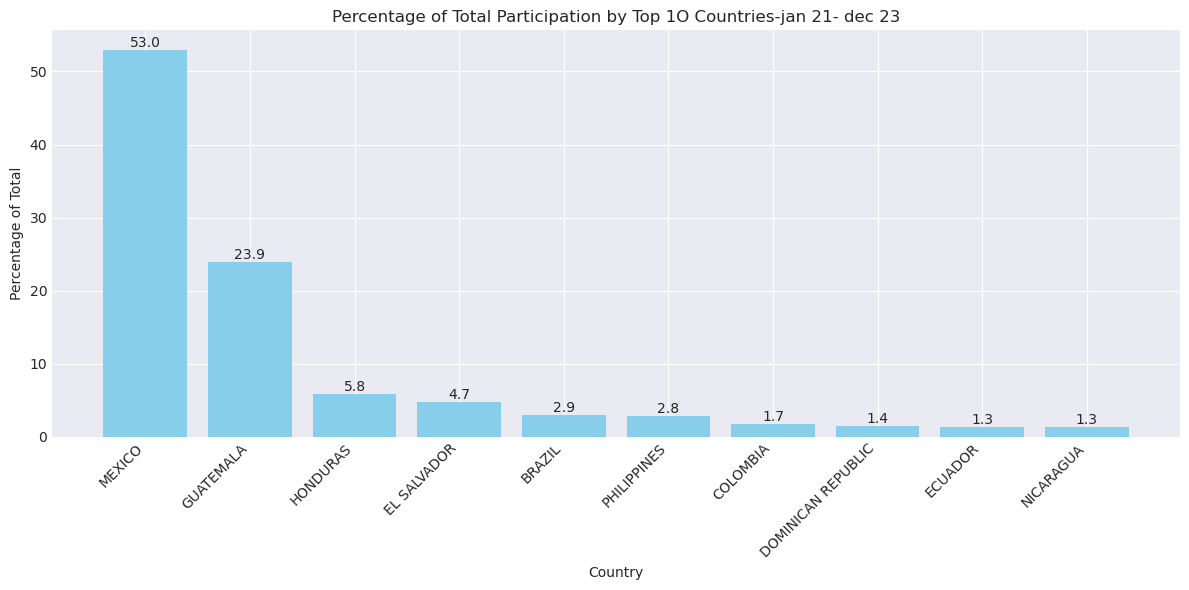

In [16]:
# Graph bars
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_countries['country'], top_10_countries['country_participation'], color='skyblue')
plt.title('Percentage of Total Participation by Top 1O Countries-jan 21- dec 23')
plt.xlabel('Country')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom',fontsize=10)

plt.tight_layout()
plt.show()

In [17]:
##WEIGHT  OF EACH PAYER (01/01/21-18/12/23)##
# Calculate the total amount
total_amount = final_df['amount'].sum()

# Calculate the participation of each country
final_df['participation'] =  final_df['amount'] / total_amount

# Group and sum the amount by country
total_amount_per_payer =  final_df.groupby('payer_country')['amount'].sum()

# Get the top 40 payers
top_40_payers = total_amount_per_payer.sort_values(ascending=False).head(40)

# Calculate the percentage of each country relative to the total amount
percentage_of_total = (top_40_payers / total_amount) * 100

# Calculate the cumulative sum of participations
cumulative_participation = percentage_of_total.cumsum()

# Create a DataFrame with the amounts, percentages, and cumulative participations
top_40_df = pd.DataFrame({'amount': top_40_payers, 
                          'percentage_of_total': percentage_of_total,
                          'cumulative_participation': cumulative_participation})

top_40_df['payer_country'] =top_40_df.index
top_40_df['country_name'] = top_40_df['payer_country'].str.split('_').str[1]

#print(top_40_df)

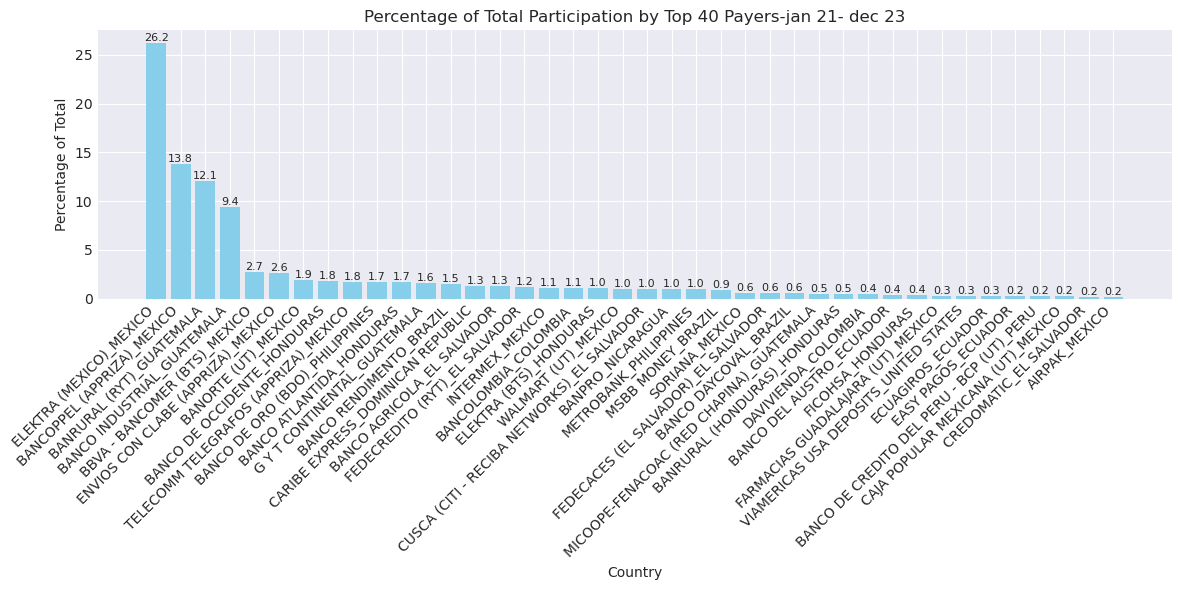

In [18]:
# Graph bars
plt.figure(figsize=(12, 6))
bars = plt.bar(top_40_df['payer_country'], top_40_df['percentage_of_total'], color='skyblue')
plt.title('Percentage of Total Participation by Top 40 Payers-jan 21- dec 23')
plt.xlabel('Country')
plt.ylabel('Percentage of Total')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom',fontsize=8)

plt.tight_layout()
plt.show()

### SEASONAL BEHAVIOR OF DATA (ELEKTRA MEXICO EXAMPLE)

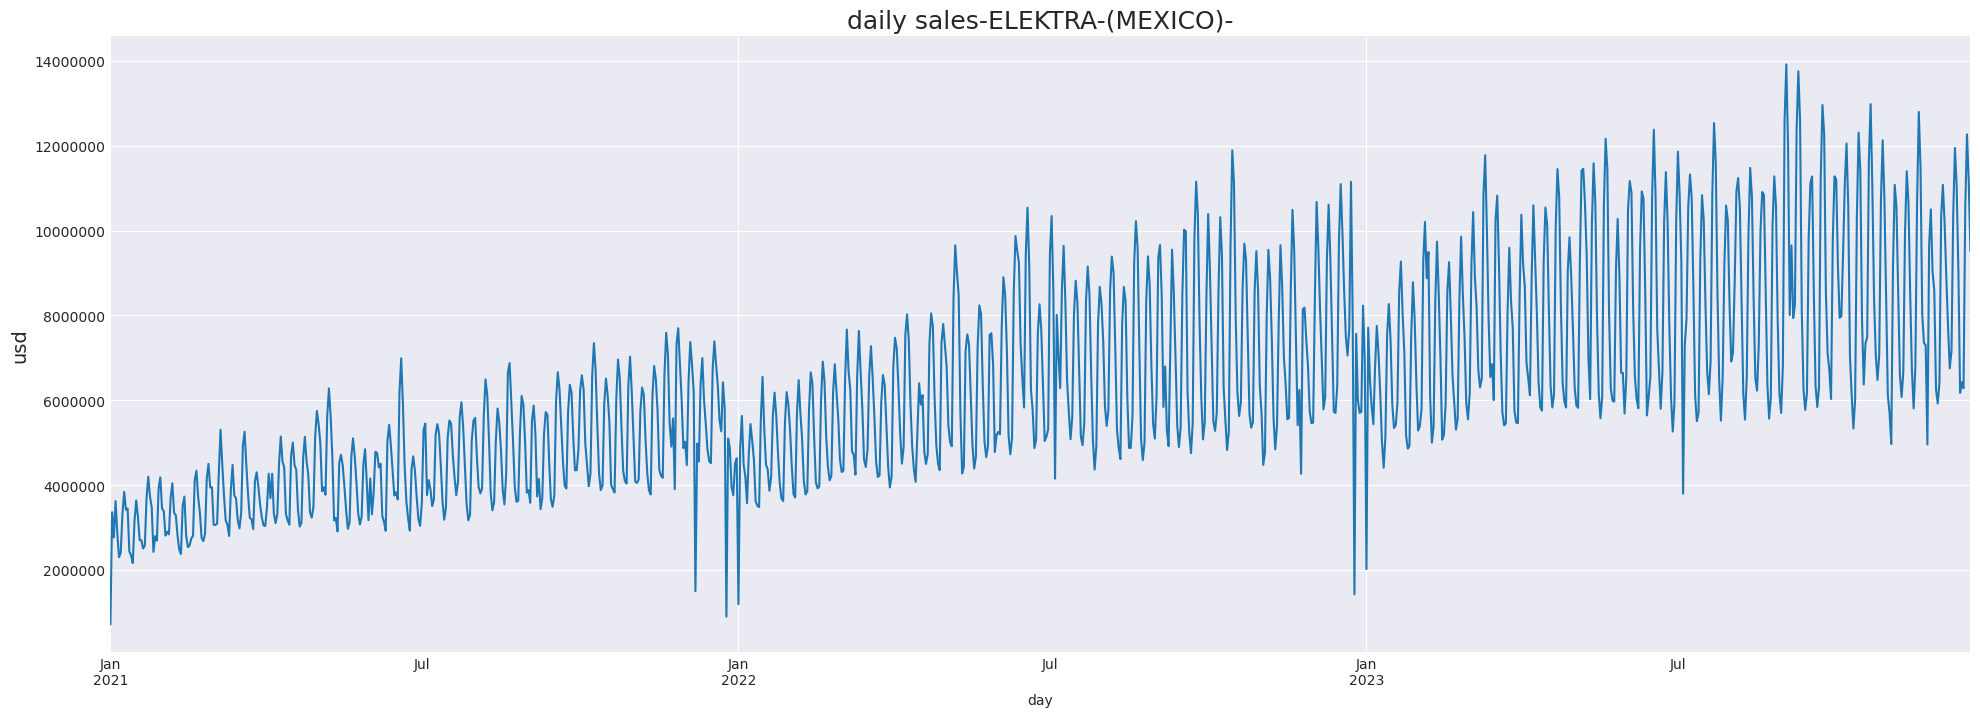

In [19]:
plt.ticklabel_format(style='plain', axis='y') 
ax = datos['amount'].plot(figsize=(24, 8))
ax.set_ylabel('usd', fontsize=14)
ax.set_xlabel('day')
ax.set_title('daily sales-ELEKTRA-(MEXICO)-', fontsize=18)
plt.show()

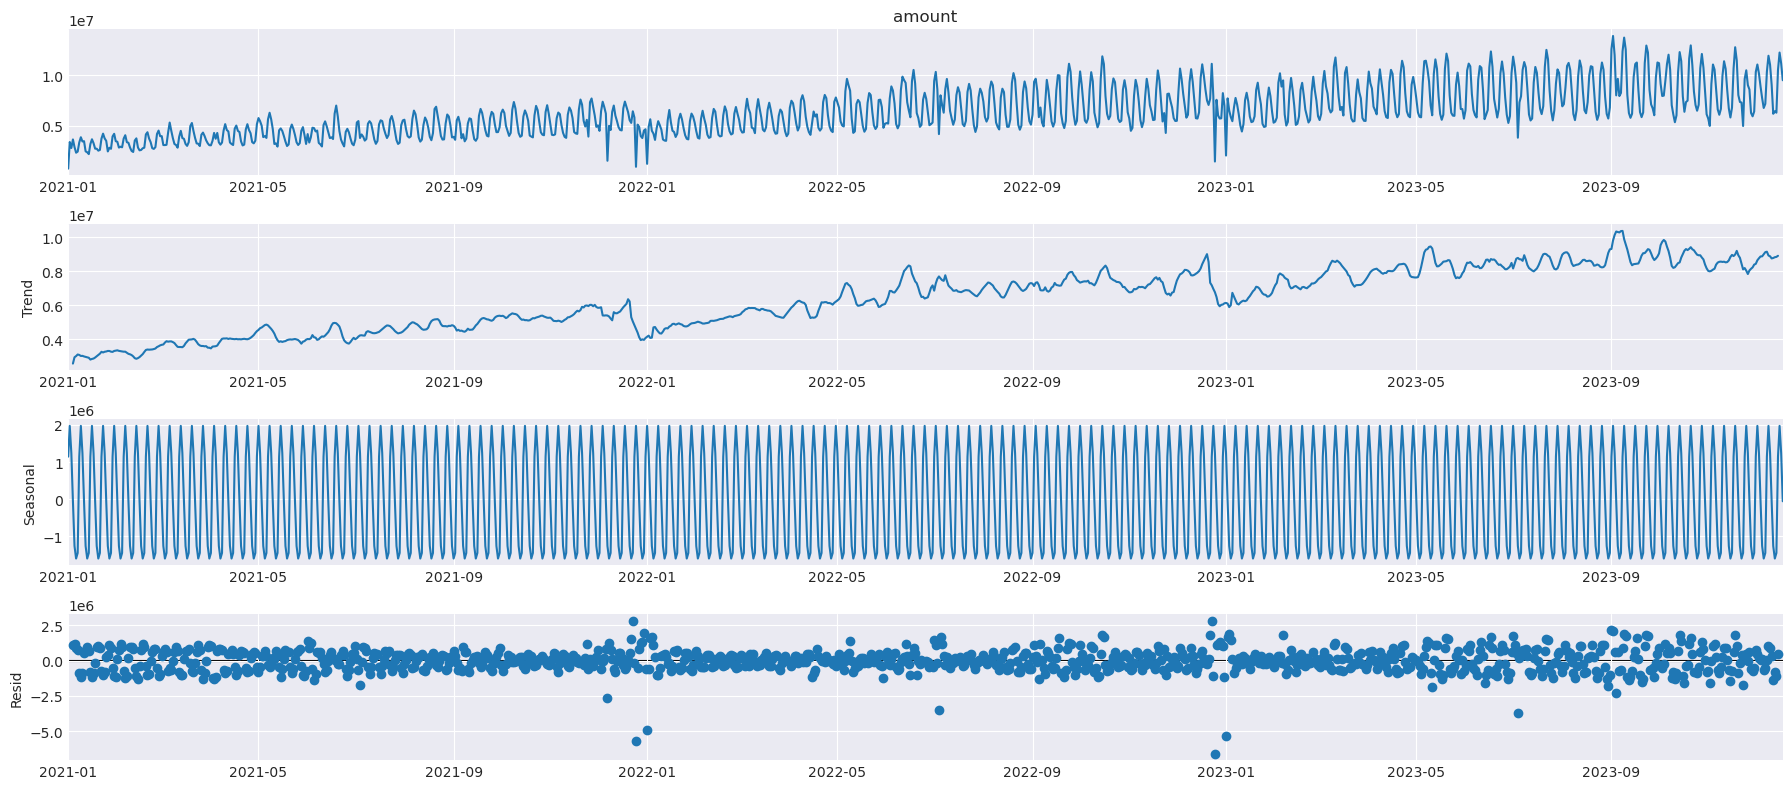

In [20]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(datos['amount'], model='additive', period=None) #multiplicative, additive
fig = decomposition.plot()
plt.show()

### CLUSTER ANALYSIS

In [21]:
final_df['var_rate_lag_1_porc']= final_df.var_rate_lag_1 / final_df.max_feed_price

In [22]:
final_df['var_rate_lag_1_porc'].fillna(0, inplace=True)

In [23]:
final_df.var_rate_lag_1_porc.describe()

count    113620.000000
mean         -0.000024
std           0.002626
min          -0.056276
25%           0.000000
50%           0.000000
75%           0.000000
max           0.044909
Name: var_rate_lag_1_porc, dtype: float64

In [24]:
final_df2=final_df.groupby('payer_country').agg({'tx': 'mean', 'amount': 'mean', 'margin': 'mean', 'var_rate_lag_1_porc': 'mean' }).reset_index()

In [25]:
final_df2.head(5)

,payer_country,tx,amount,margin,var_rate_lag_1_porc
0,24XORO_MEXICO,46.649660,35937.117653,10.177723,-0.000247
1,ABANK (TN)_EL SALVADOR,73.391867,15287.376470,1.665621,0.000000
2,AFEX_CHILE,6.381701,2859.495638,5.873089,0.000000
3,AFRO INTERNACIONAL_GUINEA,0.378538,154.762276,0.645193,0.000000
4,AFRO INTERNACIONAL_SIERRA LEONE,27.494712,8845.356769,2.159425,0.000000


In [26]:
final_df3=final_df2.copy()

In [27]:
final_df3=final_df3[['payer_country','amount', 'tx', 'margin', 'var_rate_lag_1_porc']]

In [28]:
final_df3.rename(columns={'amount': 'amount_orig', 'tx': 'tx_orig', 'margin': 'margin_orig','var_rate_lag_1_porc': 'var_rate_lag_1_porc_orig'}, inplace=True)

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
var_norm=['amount', 'margin', 'tx', 'var_rate_lag_1_porc']
final_df2[var_norm] = scaler.fit_transform(final_df2[var_norm])

In [30]:
final_df2.head()

,payer_country,tx,amount,margin,var_rate_lag_1_porc
0,24XORO_MEXICO,-0.249879,-0.218177,3.919240,-2.466321
1,ABANK (TN)_EL SALVADOR,-0.231902,-0.246988,-0.587207,0.287301
2,AFEX_CHILE,-0.276950,-0.264328,1.640296,0.287301
3,AFRO INTERNACIONAL_GUINEA,-0.280985,-0.268101,-1.127439,0.287301
4,AFRO INTERNACIONAL_SIERRA LEONE,-0.262756,-0.255976,-0.325779,0.287301


In [31]:
total_sales = final_df2[['payer_country','amount', 'tx', 'margin', 'var_rate_lag_1_porc']]

In [32]:
from sklearn.cluster import KMeans

# Inicializar el modelo de KMeans
num_clusters = 6  # Ajustar
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

In [33]:
total_sales.head()

,payer_country,amount,tx,margin,var_rate_lag_1_porc
0,24XORO_MEXICO,-0.218177,-0.249879,3.919240,-2.466321
1,ABANK (TN)_EL SALVADOR,-0.246988,-0.231902,-0.587207,0.287301
2,AFEX_CHILE,-0.264328,-0.276950,1.640296,0.287301
3,AFRO INTERNACIONAL_GUINEA,-0.268101,-0.280985,-1.127439,0.287301
4,AFRO INTERNACIONAL_SIERRA LEONE,-0.255976,-0.262756,-0.325779,0.287301


In [34]:
data_for_clustering = total_sales[['amount', 'tx', 'margin', 'var_rate_lag_1_porc']]

In [35]:
kmeans.fit(data_for_clustering) #Entreno

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1ab6c29ab0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_v

KMeans(n_clusters=6, random_state=42)

In [36]:
total_sales['cluster'] = kmeans.labels_ # Pongo etiquetas

/tmp/ipykernel_17/2179801798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_sales['cluster'] = kmeans.labels_ # Pongo etiquetas


In [37]:
cluster_stats = total_sales.groupby('cluster').agg({
    'tx': ['mean', 'std', 'min', 'max'], 
    'amount': ['mean', 'std', 'min', 'max'],
    'margin': ['mean', 'std', 'min', 'max'],
    'var_rate_lag_1_porc': ['mean', 'std', 'min', 'max']
})

cluster_stats

tx                                  amount                      \
             mean       std       min       max      mean       std       min   
cluster                                                                         
0       -0.208774  0.147523 -0.281056  0.250630 -0.195748  0.152781 -0.267985   
1       -0.178290  0.199606 -0.281201  0.579331 -0.190121  0.142871 -0.268279   
2        3.889751  1.298493  2.508456  5.085474  3.994925  1.152951  2.928273   
3        8.674182       NaN  8.674182  8.674182  8.630126       NaN  8.630126   
4        0.016590  0.274964 -0.278578  0.654951  0.028929  0.299787 -0.265735   
5       -0.280039       NaN -0.280039 -0.280039 -0.266918       NaN -0.266918   

                     margin                               var_rate_lag_1_porc  \
              max      mean       std       min       max                mean   
cluster                                                                         
0        0.344317  0.776179  0.835671  0.145878  3.142228            0.339348   
1        0.315312 -0.610569  0.453961 -2.287518  0.053184            0.365331   
2        5.218168  0.307571  0.347781  0.068928  0.706604           -0.366014   
3        8.630126  0.506105       NaN  0.506105  0.506105           -1.447215   
4        0.651115  1.119347  1.132573 -0.444052  3.919240           -1.554028   
5       -0.266918  0.866461       NaN  0.866461  0.866461           -6.943783   

                                       
              std       min       max  
cluster                                
0        0.226461  0.287301  1.540857  
1        0.415061 -1.413579  1.741694  
2        1.251067 -1.810622  0.356290  
3             NaN -1.447215 -1.447215  
4        0.499341 -2.687651 -0.675520  
5             NaN -6.943783 -6.943783

In [38]:
final_df4=pd.merge(total_sales, final_df3, on='payer_country', how='left', indicator=True)

In [39]:
final_df4._merge.value_counts()

_merge
both          133
left_only       0
right_only      0
Name: count, dtype: int64

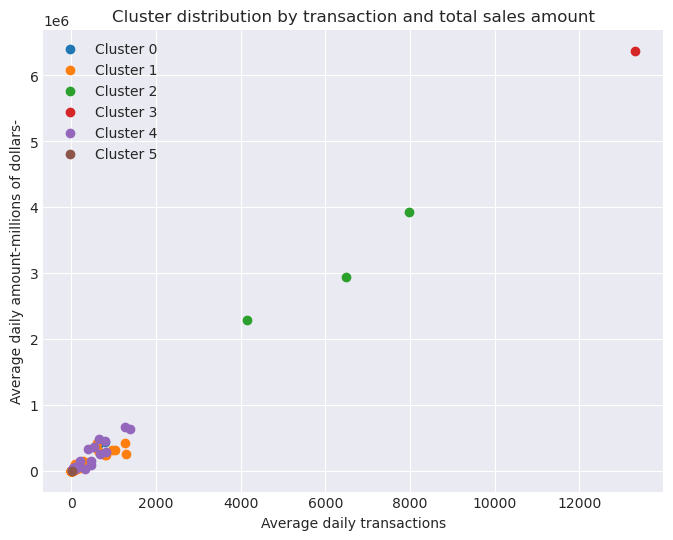

In [40]:
import matplotlib.pyplot as plt

# Scatter plot by cluster
plt.figure(figsize=(8, 6))  # Set the figure size for the plot

# Iterate through each unique cluster label in the 'daily_transactions' dataset
for cluster_label in sorted(final_df4['cluster'].unique()):
    # Filter data for the current cluster label
    cluster_data = final_df4[final_df4['cluster'] == cluster_label]
    
    # Create a scatter plot for the current cluster
    plt.scatter(cluster_data['tx_orig'], cluster_data['amount_orig'], label=f'Cluster {cluster_label}')

# Set labels for the X and Y axes
plt.xlabel('Average daily transactions')
plt.ylabel('Average daily amount-millions of dollars-' )

# Set the title for the plot
plt.title('Cluster distribution by transaction and total sales amount')

# Display the legend based on cluster labels
plt.legend()

# Show the plot
plt.show()

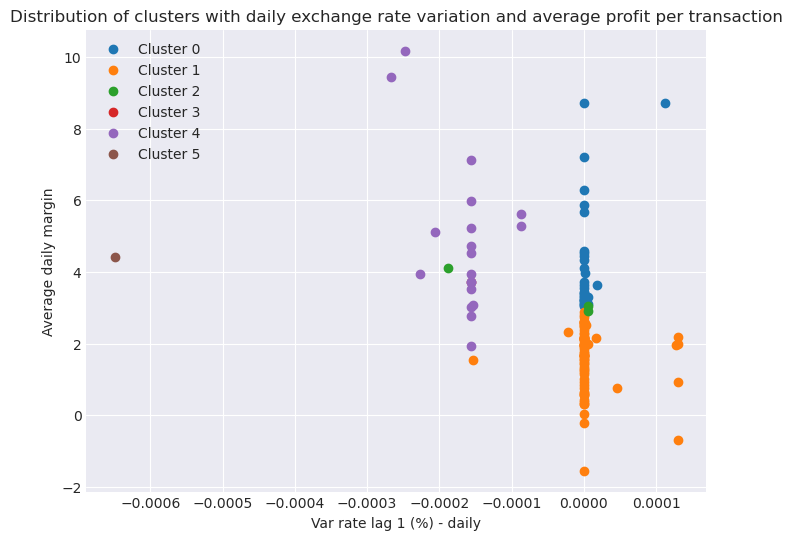

In [41]:
# Scatter plot by cluster
plt.figure(figsize=(8, 6))  # Set the figure size for the plot

# Iterate through each unique cluster label in the 'daily_transactions' dataset
for cluster_label in sorted(final_df4['cluster'].unique()):
    # Filter data for the current cluster label
    cluster_data = final_df4[final_df4['cluster'] == cluster_label]
    
    # Create a scatter plot for the current cluster
    plt.scatter(cluster_data['var_rate_lag_1_porc_orig'], cluster_data['margin_orig'], label=f'Cluster {cluster_label}')

# Set labels for the X and Y axes
plt.xlabel('Var rate lag 1 (%) - daily')
plt.ylabel('Average daily margin')

# Set the title for the plot
plt.title('Distribution of clusters with daily exchange rate variation and average profit per transaction')

# Display the legend based on cluster labels
plt.legend()

# Show the plot
plt.show()

In [42]:
total_sales.groupby('cluster')['payer_country'].nunique().reset_index()

,cluster,payer_country
0,0,31
1,1,78
2,2,3
3,3,1
4,4,19
5,5,1


In [43]:
total_sales[total_sales['cluster'] == 5]['payer_country'].unique() # Listado de cluster 5

array(['CAJA POPULAR LAS HUASTECAS (UT)_MEXICO'], dtype=object)

In [44]:
total_sales[total_sales['cluster'] == 4]['payer_country'].unique() # Listado de cluster 4

array(['24XORO_MEXICO', 'AIRPAK_MEXICO', 'BANCO DAYCOVAL_BRAZIL',
       'BANCO RENDIMENTO_BRAZIL', 'BANORTE (UT)_MEXICO',
       'BBVA - BANCOMER (BTS)_MEXICO',
       'CAJA POPULAR MEXICANA (UT)_MEXICO',
       'EMPENOS DEL SUR (ANTERIOR BALSAS)_MEXICO',
       'ENVICON (ANTERIORMENTE ENVIOS CONFIANZA)_MEXICO',
       'ENVIOS CON CLABE (APPRIZA)_MEXICO',
       'FARMACIAS GUADALAJARA (UT)_MEXICO', 'INTERMEX_MEXICO',
       'MSBB MONEY_BRAZIL', 'OXXO (TN)_MEXICO', 'SORIANA_MEXICO',
       'TELECOMM TELEGRAFOS (APPRIZA)_MEXICO', 'TRANSFER DIRECTO_MEXICO',
       'WALDOS (APPRIZA)_MEXICO', 'WALMART (UT)_MEXICO'], dtype=object)

In [45]:
total_sales[total_sales['cluster'] == 3]['payer_country'].unique() # Listado de cluster 3

array(['ELEKTRA (MEXICO)_MEXICO'], dtype=object)

In [46]:
total_sales[total_sales['cluster'] == 2]['payer_country'].unique() # Listado de cluster 2

array(['BANCO INDUSTRIAL_GUATEMALA', 'BANCOPPEL (APPRIZA)_MEXICO',
       'BANRURAL (RYT)_GUATEMALA'], dtype=object)

In [47]:
total_sales[total_sales['cluster'] == 1]['payer_country'].unique() # Listado de cluster 1

array(['ABANK (TN)_EL SALVADOR', 'AFRO INTERNACIONAL_GUINEA',
       'AFRO INTERNACIONAL_SIERRA LEONE', 'ARGENPER_BOLIVIA',
       'BANCO AGRICOLA_EL SALVADOR', 'BANCO ATLANTIDA_HONDURAS',
       'BANCO BISA_BOLIVIA',
       'BANCO DAVIVIENDA SALVADORENO (BTS)_EL SALVADOR',
       'BANCO DE CREDITO DEL PERU - BCP (UT)_PERU',
       'BANCO DE GUAYAQUIL_ECUADOR', 'BANCO DE ORO (BDO)_PHILIPPINES',
       'BANCO DEL AUSTRO_ECUADOR', 'BANCO GANADERO (BOLIVIA)_BOLIVIA',
       'BANCO INDUSTRIAL ELS (RED CHAPINA)_EL SALVADOR',
       'BANCO PICHINCHA (TN)_ECUADOR',
       'BANCO POPULAR HONDURAS (UT)_HONDURAS',
       'BANK OF PHILIPPINE ISLANDS (BPI)_PHILIPPINES', 'BANPRO_NICARAGUA',
       'BANRURAL (HONDURAS)_HONDURAS', 'BNB_GHANA', 'BNB_LIBERIA',
       'BNB_SENEGAL', 'BNB_SIERRA LEONE',
       'CARIBE EXPRESS_DOMINICAN REPUBLIC',
       'CEBUANA LHUILLIER_PHILIPPINES', 'COOPERATIVA CACIL (UT)_HONDURAS',
       'COOPERATIVA FRONTERIZA (UT)_HONDURAS',
       'CREDOMATIC (BTS)_NICARAGUA', '

In [48]:
total_sales[total_sales['cluster'] == 0]['payer_country'].unique() # Listado de cluster 0

array(['AFEX_CHILE', 'ARGENPER_ARGENTINA', 'ARGENPER_CHILE',
       'ARGENPER_PERU', 'BAM - BANCO AGROMERCANTIL (UT)_GUATEMALA',
       'BANCO BHD LEON_DOMINICAN REPUBLIC', 'BANCO DE OCCIDENTE_HONDURAS',
       'BANCOLOMBIA_COLOMBIA', 'BANHCAFE_HONDURAS',
       'BANPAIS (RED CHAPINA)_HONDURAS', 'BANTRAB (UT)_GUATEMALA',
       'FICOHSA_HONDURAS', 'G Y T CONTINENTAL_GUATEMALA', 'GME_NEPAL',
       'LAFISE_NICARAGUA', 'MERCHANTRADE_INDONESIA',
       'MICOOPE-FENACOAC (RED CHAPINA)_GUATEMALA', 'NAFA_GAMBIA, THE',
       'NAFA_GUINEA', 'NAFA_TOGO', 'NAIRAGRAM_NIGERIA',
       'TRANSFERTO - THUNES_ITALY', 'TRANSFERTO - THUNES_NIGERIA',
       'TRANSFERTO - THUNES_PORTUGAL', 'TRANSFERTO - THUNES_SPAIN',
       'TRANSPAY_INDONESIA', 'UNITRANSFER_HAITI',
       'VIAMERICAS USA DEPOSITS_UNITED STATES', 'VTN_NIGERIA',
       'YES BANK_INDIA', 'ZEEPAY_GHANA'], dtype=object)